# 1 Notebook Setup

In [1]:
import os
import sys
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import pandas as pd
import numpy as np
import pickle
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Add src folder to environmental path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'src')))

# 2 Loading model & extracted event, creating ECLG

In [3]:
# To keep root folder intact, load inputs from tutorial directory 'examples/input/'
in_dir = 'input'
isExist = os.path.exists(in_dir)
if not isExist:
    os.makedirs(in_dir)

In [4]:
# support your input baseline model here
model_file = 'BooleanTcell_biorecipe.xlsx'
baseline = os.path.join(in_dir, model_file)

In [5]:
# Load baseline model file into two dictionaries
# we highlight the key information of the baseline model
from runClarinet import get_model
model_dict, regulators = get_model(baseline)
df_model = pd.read_excel(baseline, index_col=0)
df_model[['Element Name','Element IDs','Positive Regulation Rule','Negative Regulation Rule','Levels','State List 0']]

,Element Name,Element IDs,Positive Regulation Rule,Negative Regulation Rule,Levels,State List 0
#,,,,,,
1,AKT,P31749,"(PDK1,MTORC2)",AKT_OFF,2,0
2,AKT_OFF,P31749,NaN,NaN,2,0
3,AP1,"P05412,P01100","(FOS_DD,JUN)",NaN,2,0
4,CA,NaN,TCR,NaN,2,0
5,CD122,P14784,NaN,NaN,2,1
...,...,...,...,...,...,...
58,TCR_HIGH,"P01850,P01848",NaN,NaN,2,0
59,TCR_LOW,"P01850,P01848",NaN,NaN,2,0
60,TGFBETA,P01137,NaN,NaN,2,0


In [6]:
# 'model_dict' is a dictionary that holds critical information of each baseline model element
# 'regulators' is another dictionary that contains baseline model elements and corresponding regulator elements
# model_dict
regulators

{'AKT': {'AKT_OFF', 'MTORC2', 'PDK1'},
 'AKT_OFF': set(),
 'AP1': {'FOS_DD', 'JUN'},
 'CA': {'TCR'},
 'CD122': set(),
 'CD132': set(),
 'CD25': {'AP1', 'FOXP3', 'NFAT', 'NFKAPPAB', 'STAT5'},
 'CD28': set(),
 'ERK': {'MEK2'},
 'FOS': {'ERK'},
 'FOS_D': {'FOS'},
 'FOS_DD': {'FOS_D'},
 'FOS_DDD': set(),
 'FOXP3': {'MTOR_DD', 'NFAT', 'SMAD3', 'STAT5'},
 'IL2': {'AP1', 'FOXP3', 'IL2', 'NFAT', 'NFKAPPAB'},
 'IL2_EX': {'IL2', 'IL2_EX'},
 'IL2R': {'CD122', 'CD132', 'CD25'},
 'JAK3': {'IL2R', 'IL2_EX'},
 'JNK': {'MKK7'},
 'JUN': {'JNK'},
 'MEK2': {'RAF'},
 'MKK7': {'TAK1'},
 'MTOR': {'MTORC1_D', 'MTORC2_D'},
 'MTOR_D': {'MTOR'},
 'MTOR_DD': {'MTOR_D'},
 'MTOR_DDD': set(),
 'MTOR_DDDD': set(),
 'MTORC1': {'MTORC1_OFF', 'RHEB'},
 'MTORC1_D': {'MTORC1'},
 'MTORC1_OFF': set(),
 'MTORC2': {'PI3K_HIGH', 'PI3K_LOW', 'S6K1'},
 'MTORC2_D': {'MTORC2'},
 'MTORC2_DD': set(),
 'NFAT': {'CA', 'NFAT_OFF'},
 'NFAT_OFF': set(),
 'NFKAPPAB': {'AKT', 'PKCTHETA'},
 'PDK1': {'PIP3'},
 'PI3K': {'PI3K_HIGH', 'PI3K_LO

In [7]:
# support your another input (extracted event information) here, it is from machine reading
reading_file = 'ReadingOutput_biorecipe.csv'
reading = os.path.join(in_dir, reading_file)

In [8]:
# we highlight the key information of each event
df_ro = pd.read_csv(reading)
df_ro[['Regulator Name', 'Regulator ID', 'Regulated Name','Regulated ID', 'Sign', 'Paper IDs']]

,Regulator Name,Regulator ID,Regulated Name,Regulated ID,Sign,Paper IDs
0,AKT,P31749,CD4,P01730,negative,PMC2275380
1,AKT,P31749,CTRL,P40313,negative,PMC2275380
2,TGFBETA,P01137,AKT,P31749,positive,PMC2275380
3,Foxp3,Q9BZS1,Ctla4,P16410,positive,PMC2275380
4,Foxp3,Q9BZS1,Gpr83,Q9NYM4,positive,PMC2275380
...,...,...,...,...,...,...
112,MTORC2,Q6R328,MTORC2,Q6R327,positive,PMC4418530
113,CD28,P10747,MTORC2,Q6R328,positive,PMC4418530
114,IL2_EX,P60568,MTORC2,Q6R329,positive,PMC4418530
115,IL2_R,P01589,MTORC2,Q6R330,positive,PMC4418530


In [9]:
# create Event CoLlaboration Graph
from runClarinet import create_eclg
G = create_eclg(reading, model_dict)

INFO:root:Number of unique paper IDs: 12
INFO:root:Average interactions per paper: 9.75


In [10]:
# show the nodes in Event CoLlaboration Graph
# node name encodes the interaction it represents, in the form of:
# regulator -> regulated element -> + or -
G.nodes()

NodeView(('AKT->CD4_ext->-', 'AKT->CTRL_ext->-', 'TGFBETA->AKT->+', 'FOXP3->Ctla4_ext->+', 'FOXP3->Gpr83_ext->+', 'PTEN->CD8_ext->+', 'PTEN->HSC_ext->+', 'CHK1_ext->AKT->+', 'FOXO1->Foxo3a_ext->-', 'IQGAP1_ext->MEK2->-', 'MEK1_ext->AKT->-', 'AKT->MEK1_ext->-', 'AKT->MAGI1_ext->-', 'ERK->S5B_ext->+', 'MEK2->PTEN->+', 'TCR->CD4_ext->-', 'Itk_ext->CD4_ext->-', 'AKT->Itk_ext->-', 'FOXP3->Itk_ext->+', 'Itk_ext->CD4_ext->+', 'IL2->Itk_ext->+', 'TCR->Itk_ext->+', 'TCR->PTEN->-', 'PTEN->Itk_ext->-', 'Itk_ext->Th17_ext->+', 'CD4_ext->IL17A_ext->-', 'HIF1alpha_ext->IL17A_ext->-', 'TCR->CD25->+', 'Itk_ext->Myc_ext->-', 'AKT->TBK1_ext->+', 'MTOR->TBK1_ext->+', 'TCR->AKT->-', 'TBK1_ext->AKT->-', 'AKT->FOXO1->-', 'TBK1_ext->CD4_ext->-', 'TBK1_ext->FOXO1->+', 'TBK1_ext->AKT->+', 'TBK1_ext->CD4_ext->+', 'TCR->NEDD4_ext->+', 'FOXO1->PTEN->+', 'MEK1_ext->PTEN->+', 'CK2_ext->PTEN->-', 'NEDD4_ext->PTEN->-', 'PIP3->AKT->+', 'MTORC2->AKT->+', 'TCR->MTORC2->+', 'AKT->MTORC2->-', 'TCR->PIP3->+', 'PTEN->PIP3->

In [11]:
# show some characteristics of the ECLG gragh
print('Number of nodes in the ECLG graph:', len(G.nodes()))
print('Number of edges in the ECLG graph:', len(G.edges()))
his_before = nx.degree_histogram(G)
print('Node degress distribution histogram: ',his_before)

Number of nodes in the ECLG graph: 95
Number of edges in the ECLG graph: 512
Node degress distribution histogram:  [0, 0, 3, 5, 9, 6, 0, 5, 18, 2, 0, 0, 0, 0, 28, 0, 0, 15, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]


# 3 Processing and weighting ECLG 

In [12]:
from runClarinet import node_weighting, edge_weighting

In [13]:
# To keep root folder intact, generate output in tutorial directory 'examples/output'
out_dir = 'output'

isExist = os.path.exists(out_dir)
if not isExist:
    os.makedirs(out_dir)

In [14]:
# set a parameter FC_TH
FC_TH = 2

In [15]:
# assign weights to nodes using frequency class
# in the meantime, remove the less frequent nodes
G = node_weighting(G, FC_TH, out_dir)

In [16]:
# show some characteristics of the ECLG gragh after removing less frequent nodes
print('Number of nodes in the ECLG graph:', len(G.nodes()))
print('Number of edges in the ECLG graph:', len(G.edges()))
his_after = nx.degree_histogram(G)
print('Node degress distribution histogram: ',his_after)

Number of nodes in the ECLG graph: 72
Number of edges in the ECLG graph: 465
Node degress distribution histogram:  [0, 0, 0, 0, 0, 0, 0, 5, 20, 0, 0, 0, 0, 0, 29, 0, 0, 15, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]


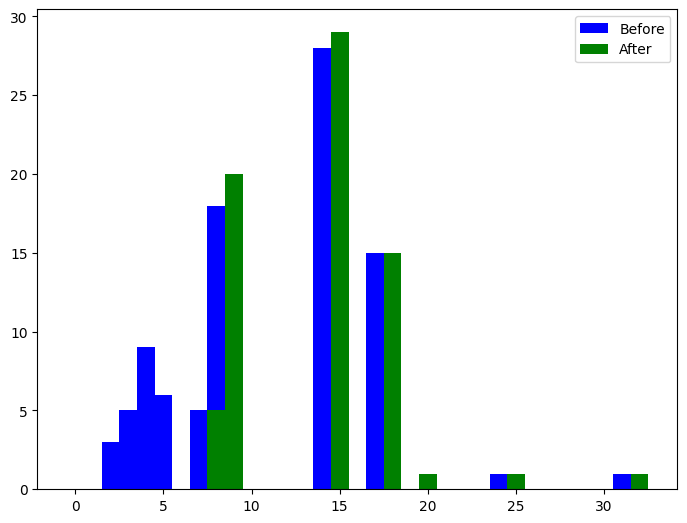

In [17]:
# draw a histogram comparison between before and after removing less frequent nodes
matched_his = max(len(his_before), len(his_after))
X = np.arange(matched_his)
while len(his_before)<matched_his:
    his_before.append(0)
while len(his_after)<matched_his:
    his_after.append(0)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X  , his_before, color = 'b', width = 1)
ax.bar(X +1, his_after, color = 'g', width = 1)
ax.legend(labels=['Before', 'After'])
plt.show()

In [18]:
# assign weights to edges using frequency class
# other ways to assign weights to edges are also available, e.g., set weightMethod = 'IF'
weightMethod = 'FC'
G = edge_weighting(G, out_dir, weightMethod)

# 4 Clustering ECLG

INFO:root:Community centered at "AKT->MTORC2->-->1"(community label is 0) has 18 interactions:
['TCR->NEDD4_ext->+->1', 'FOXO1->PTEN->+->1', 'MEK1_ext->PTEN->+->1', 'CK2_ext->PTEN->-->1', 'NEDD4_ext->PTEN->-->0', 'PIP3->AKT->+->1', 'MTORC2->AKT->+->1', 'TCR->MTORC2->+->1', 'AKT->MTORC2->-->1', 'TCR->PIP3->+->1', 'PTEN->PIP3->-->1', 'TCR->MEK1_ext->+->1', 'TCR->CK2_ext->+->1', 'MTORC2->MTORC2->+->1', 'CD28->MTORC2->+->1', 'IL2->MTORC2->+->1', 'CD25->MTORC2->+->1', 'PI3K->PIP3->+->0']

INFO:root:Community centered at "P38_ext->CD5_ext->+->2"(community label is 1) has 9 interactions:
['CK2_ext->CD4_ext->+->2', 'SP_ext->CD69_ext->+->2', 'CK2_ext->CDC37_ext->+->2', 'CK2_ext->AKT->+->2', 'ERK->CK2_ext->+->2', 'Bcl2_ext->CD3_ext->+->2', 'CD5_ext->CK2_ext->+->2', 'CD5_ext->P38_ext->+->2', 'P38_ext->CD5_ext->+->2']

INFO:root:Community centered at "Itk_ext->CD4_ext->-->1"(community label is 2) has 15 interactions:
['AKT->CD4_ext->-->1', 'TCR->CD4_ext->-->1', 'Itk_ext->CD4_ext->-->1', 'AKT->Itk_

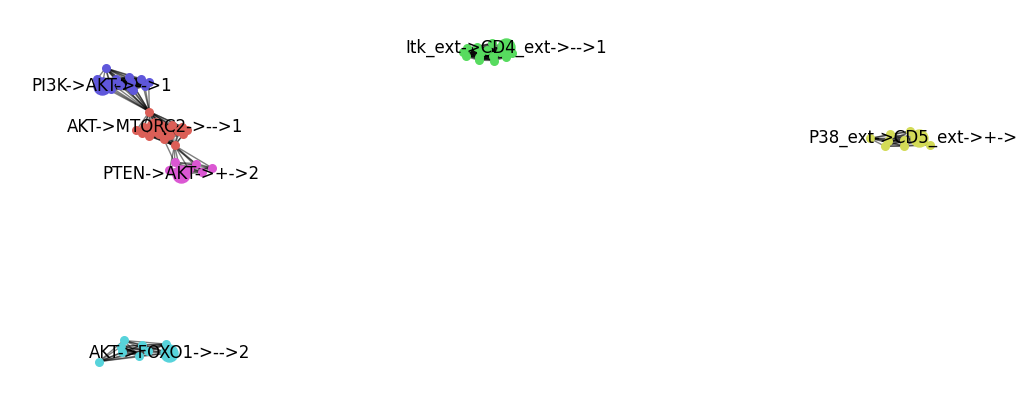

In [19]:
# cluster the ECLG using the community detection algorithm
# and save each cluster in a separate file

from runClarinet import clustering, merge_clusters, get_cluster_info
clustering(G, out_dir)

In [20]:
# check out the grouped extension
pickle.load(open(os.path.join(out_dir, "grouped_ext"),'rb'))

[[1,
  ['TCR->NEDD4_ext->+->1', 'FOXO1->PTEN->+->1', 3],
  ['TCR->NEDD4_ext->+->1', 'MEK1_ext->PTEN->+->1', 3],
  ['TCR->NEDD4_ext->+->1', 'CK2_ext->PTEN->-->1', 3],
  ['TCR->NEDD4_ext->+->1', 'NEDD4_ext->PTEN->-->0', 3],
  ['TCR->NEDD4_ext->+->1', 'PIP3->AKT->+->1', 3],
  ['TCR->NEDD4_ext->+->1', 'MTORC2->AKT->+->1', 3],
  ['TCR->NEDD4_ext->+->1', 'TCR->MTORC2->+->1', 3],
  ['TCR->NEDD4_ext->+->1', 'AKT->MTORC2->-->1', 3],
  ['TCR->NEDD4_ext->+->1', 'TCR->PIP3->+->1', 3],
  ['TCR->NEDD4_ext->+->1', 'PTEN->PIP3->-->1', 3],
  ['TCR->NEDD4_ext->+->1', 'TCR->MEK1_ext->+->1', 3],
  ['TCR->NEDD4_ext->+->1', 'TCR->CK2_ext->+->1', 3],
  ['TCR->NEDD4_ext->+->1', 'MTORC2->MTORC2->+->1', 3],
  ['TCR->NEDD4_ext->+->1', 'CD28->MTORC2->+->1', 3],
  ['TCR->NEDD4_ext->+->1', 'IL2->MTORC2->+->1', 3],
  ['TCR->NEDD4_ext->+->1', 'CD25->MTORC2->+->1', 3],
  ['TCR->NEDD4_ext->+->1', 'PI3K->PIP3->+->0', 3],
  ['FOXO1->PTEN->+->1', 'MEK1_ext->PTEN->+->1', 3],
  ['FOXO1->PTEN->+->1', 'CK2_ext->PTEN->-->1', 3

In [21]:
# return basic information for each generated cluster
get_cluster_info(os.path.join(out_dir, 'GeneratedClusters'), os.path.join(out_dir, 'LSS'), out_dir)

,Cluster_index,Nodes,Edges,Density,AvgPathLength,Coeff,LSS,NodesX,EdgesX,DensityX,AvgPathLength,CoeffX,FreqClass,node_perc
12,12.0,28.0,378.0,1.000000,0.964286,1.000000,4.142857,18.0,25.0,0.163399,2.209877,0.119709,0.0,0.000000
13,13.0,28.0,378.0,1.000000,0.964286,1.000000,4.928571,29.0,27.0,0.066502,3.249501,0.041188,0.0,13.793103
8,8.0,69.0,1596.0,0.680307,1.300567,0.980914,4.683584,45.0,63.0,0.063636,2.828893,0.169441,1.0,20.000000
1,1.0,18.0,153.0,1.000000,0.944444,1.000000,3.000000,13.0,17.0,0.217949,2.201183,0.000000,2.0,76.923077
6,6.0,7.0,21.0,1.000000,0.857143,1.000000,2.904762,5.0,5.0,0.500000,1.200000,0.433333,0.0,80.000000
7,7.0,16.0,120.0,1.000000,0.937500,1.000000,4.875000,15.0,16.0,0.152381,2.951111,0.028889,0.0,33.333333
9,9.0,11.0,55.0,1.000000,0.909091,1.000000,5.000000,16.0,11.0,0.091667,1.137931,0.000000,0.0,6.250000
11,11.0,25.0,300.0,1.000000,0.960000,1.000000,4.100000,14.0,21.0,0.230769,1.743243,0.308844,0.0,21.428571
10,10.0,22.0,231.0,1.000000,0.954545,1.000000,4.090909,18.0,18.0,0.117647,2.277778,0.013448,0.0,38.888889
5,5.0,14.0,91.0,1.000000,0.928571,1.000000,2.571429,16.0,14.0,0.116667,1.969231,0.000000,0.0,25.000000


In [22]:
# set another parameter ReturnTh
ReturnTh = 2

In [23]:
#prints labels of communities to be merged based on the existence of more than N=ReturnTh return paths.
#it also generates and saves the grouped_ext_Merged pickle file that contains the merged clusters.
merge_clusters(regulators, out_dir, ReturnTh)

INFO:root:Merge clusters NO.1 and NO.6
INFO:root:Merge clusters NO.3 and NO.6


In [24]:
# check out the merged grouped extension
pickle.load(open(os.path.join(out_dir, "grouped_ext_Merged"),'rb'))

[[1,
  ['FOXO1', 'PTEN', '+'],
  ['PTEN', 'PIP3', '-'],
  ['PTEN', 'AKT', '+'],
  ['MEK1_ext', 'PTEN', '+'],
  ['CK2_ext', 'PTEN', '-'],
  ['NEDD4_ext', 'PTEN', '-'],
  ['PIP3', 'AKT', '+'],
  ['AKT', 'MTORC2', '-'],
  ['MTORC2', 'AKT', '+'],
  ['MTORC2', 'MTORC2', '+'],
  ['TCR', 'MTORC2', '+'],
  ['TCR', 'PIP3', '+'],
  ['TCR', 'MEK1_ext', '+'],
  ['TCR', 'CK2_ext', '+'],
  ['CD28', 'MTORC2', '+'],
  ['IL2', 'MTORC2', '+'],
  ['CD25', 'MTORC2', '+'],
  ['PI3K', 'PIP3', '+'],
  ['PI3K', 'PTEN', '+']],
 [2,
  ['TCR', 'CD4_ext', '-'],
  ['TCR', 'Itk_ext', '+'],
  ['TCR', 'PTEN', '-'],
  ['TCR', 'CD25', '+'],
  ['CD4_ext', 'IL17A_ext', '-'],
  ['Itk_ext', 'CD4_ext', '+'],
  ['Itk_ext', 'Th17_ext', '+'],
  ['Itk_ext', 'Myc_ext', '-'],
  ['AKT', 'Itk_ext', '-'],
  ['FOXP3', 'Itk_ext', '+'],
  ['IL2', 'Itk_ext', '+'],
  ['PTEN', 'Itk_ext', '-'],
  ['PTEN', 'AKT', '+'],
  ['HIF1alpha_ext', 'IL17A_ext', '-'],
  ['PI3K', 'PTEN', '+']]]